In [30]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
today=datetime.today().strftime('%Y-%m-%d')

from tqdm import tqdm # progress apply :)
tqdm.pandas()

%load_ext autoreload
%autoreload 2
def d(l):
    pd.set_option('display.max_colwidth', l)

d(10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
df=pd.read_json("2025-06-06 Merged_Data.json")
#df["year"]=pd.to_datetime(df.Year,format="%Y", errors='coerce')
# Mapping sentiment scores to categories
df["category"]=df["category"].str.lower().fillna("none")


from ast import literal_eval
columns_to_convert=['fields', 'most_common_fields', 'NoStopwords', 'Nouns_Verbs', 'all_jobs','keywords_likely',
       'keywords_only', 'keywords_filtered']

def safe_literal_eval(val):
    try:
        return literal_eval(val)  # Attempt to parse the value
    except (ValueError, SyntaxError, TypeError):
        return val  # Return the original value if parsing fails
# Create a dictionary of converters
converters = {col: safe_literal_eval for col in columns_to_convert}

for col in columns_to_convert:
    if col in df.columns:  # Ensure the column exists in the DataFrame
        df[col] = df[col].apply(safe_literal_eval)
df.shape

(1016, 75)

In [32]:
df.loc[df.name=="Science230"].Doi

752    10.112...
Name: Doi, dtype: object

In [33]:

#df["field_3"]=df["field_3"].replace("None",None).str.split(", ")
x=df[["field_1",'fields']].explode('field_1').explode('fields').dropna()#.nunique(axis=1)
#x.country_1.value_counts()


In [34]:
df.columns

Index(['ID', 'Doi', 'journal', 'Title', 'Date', 'Year', 'Type', 'Type Recoded',
       'confirmed_2024', '9. retained for analysis (revised)', 'name',
       'contains_country', 'country_plus_city', 'Most Common country',
       'Most Common country_no_city', 'all_jobs', 'fields',
       'most_common_fields', 'path', 'folder', 'labels', 'retraction_counts',
       'text', 'sentiment', 'keywords_likely', 'keywords_only',
       'keywords_filtered', 'Lemmata', 'NoStopwords', 'Nouns_Verbs',
       'ner_orga', 'ner_person', 'misconduct', 'mistake', 'retract',
       'n_misconduct', 'n_mistake', 'n_retract', 'dict_topic', 'category_1',
       'explanation_1', 'original_index', 'name_2', 'category_2',
       'explanation_2', 'country_1', 'field_1', 'name_3', 'category_3',
       'explanation_3', 'country_3', 'field_3', 'name_4', 'category_4',
       'explanation_4', 'country_4', 'field_4', 'name_5', 'category_5',
       'explanation_5', 'country_5', 'field_5', 'name_6', 'category_6',
       

In [35]:
#dfx=df.country_plus_city_set.explode()
#dfx.value_counts()[:10].to_excel("Top10 countriesC_set.xlsx")

In [36]:
#dfx=df.fields.explode()
#dfx.value_counts()/dfx.value_counts().sum()

In [37]:
df.difference_count.value_counts()

difference_count
0    771
1    225
2     20
Name: count, dtype: int64

In [38]:
df.journal.value_counts()

journal
Nature     644
Science    372
Name: count, dtype: int64

In [39]:
allIDs=df.name.astype(str).tolist()
with open(today+'_final_data.txt', 'w') as txt:
    # Join the IDs with a specified separator, e.g., a comma
    i = ",".join(allIDs)
    txt.write(i)


In [40]:
df["most_common_fields"].dropna()#.explode().value_counts()

0       [Geogr...
1              []
2       [Chemi...
3              []
4       [Biology]
          ...    
1011    [Engin...
1012    [Medic...
1013           []
1014           []
1015    [Engin...
Name: most_common_fields, Length: 1016, dtype: object

In [41]:
df['contains_country_once']=df['contains_country'].apply(lambda x: list(set(x)) if isinstance(x,list) else x)

df['contains_country_once'].explode().value_counts()[:6]

contains_country_once
United States     171
China             120
Germany            92
Japan              81
United Kingdom     71
Canada             54
Name: count, dtype: int64

In [42]:
# Filter Text Duplications
duplicated=df[df.text.duplicated(keep=False) | (df.Doi.duplicated(keep=False))]
duplicated=duplicated[duplicated.Doi!=0]
duplicated[["text","Doi"]].to_excel("2025-04-02 Duplicated Texts.xlsx")
#df.drop_duplicates(subset="text",inplace=True)
df.shape

(1016, 76)

In [43]:
df[df.ID=="Nature1316"].category

119    mistake
Name: category, dtype: object

In [44]:
df[(df["category"]=="none") & (df["Max code"]!="none")][["Max code","name"]].dropna()

,Max code,name
117,mistake,Nature...
139,miscon...,Nature140
258,miscon...,Nature300
429,miscon...,Nature520
477,miscon...,Nature73
939,mistake,Scienc...


# Compare annotations

In [45]:
anno=pd.read_excel("2025-06-06 none_mistake sample ANNOTATED.xlsx")

anno=anno.dropna(subset="Max code")
anno.index=anno["name"]

nones=df[df["category"]=="none"].ID.to_list()
nones_in_index = [i for i in nones if i in anno.index]
anno.loc[nones_in_index].name.to_list()

['Nature140']

In [46]:

Annotated_Classified=df.dropna(subset="Max code")[["name","text","category","dict_topic","Max code"]]
Annotated_Classified.rename(columns={"Max code":"manual category","explanation_1":" GPT4 explanation","category":"GPT4 category","dict_topic":"dictionary category"},inplace=True)
Annotated_Classified=Annotated_Classified.dropna()
from sklearn.metrics import classification_report
report1=classification_report(Annotated_Classified["manual category"], Annotated_Classified["GPT4 category"], output_dict=True)
r1=(pd.DataFrame(report1).transpose())
report2=classification_report(Annotated_Classified["manual category"], Annotated_Classified["dictionary category"], output_dict=True)
r2=(pd.DataFrame(report2).transpose())

In [47]:

Annotated_Classified.to_excel("2025-06-12" + " Annotation results.xlsx")

In [48]:
print("dictionary")
r2

dictionary


,precision,recall,f1-score,support
misconduct,0.941176,0.655738,0.772947,122.00...
mistake,0.687500,0.698413,0.692913,63.000000
none,0.283333,0.708333,0.404762,24.000000
accuracy,0.674641,0.674641,0.674641,0.674641
macro avg,0.637337,0.687495,0.623541,209.00...
weighted avg,0.789168,0.674641,0.706542,209.00...


In [49]:
print("GPT4.1")
r1

GPT4.1


,precision,recall,f1-score,support
misconduct,0.910569,0.918033,0.914286,122.00...
mistake,0.812500,0.825397,0.818898,63.000000
none,0.727273,0.666667,0.695652,24.000000
accuracy,0.861244,0.861244,0.861244,0.861244
macro avg,0.816781,0.803365,0.809612,209.00...
weighted avg,0.859959,0.861244,0.860426,209.00...


In [50]:
#!pip install wordcloud

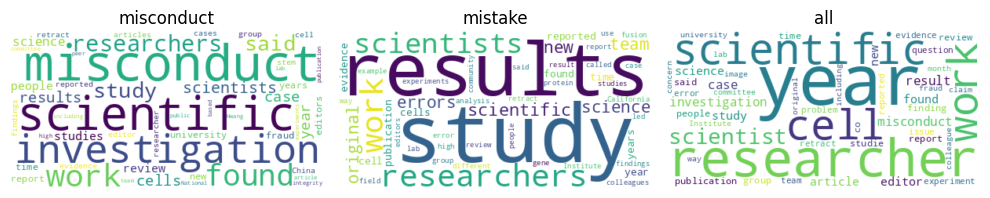

In [51]:
from collections import Counter
from wordcloud import WordCloud
all_words=[i.rstrip("s") for i in df["NoStopwords"].sum()]
MC_words_all=Counter(all_words).most_common(60)
words,counts=zip(*MC_words_all[:10])
words+=("Science","Nature")
MC_words=df.groupby("category")["NoStopwords"].apply(lambda x: Counter([a for b in x for a in b if 
                                                        (len(a)>2) & (a.rstrip("s") not in words)]).most_common(50))

MC_words["all"]=[i for i in MC_words_all if i[0].rstrip("s") not in words]
MC_words.pop("none")



# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Iterate through the categories and generate word clouds
for ax, (category, words) in zip(axes, MC_words.items()):
    word_freq = dict(words)  # Convert to a dictionary
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_freq)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')  # Hide axes
    ax.set_title(category)  # Set title for each subplot

# Save the figure as a PDF
plt.tight_layout()
plt.savefig('2025-07-07 wordclouds.pdf', format='pdf', dpi = 1500)
plt.show()

In [52]:
df['contains_country'].apply(lambda x: len(x)>1).value_counts()

contains_country
False    629
True     387
Name: count, dtype: int64

In [53]:
df['fields'] = df['fields'].apply(lambda d: d if isinstance(d, list) else [])
df['fields_set'] = df['fields'].apply(lambda d: list(set(d)) if isinstance(d, list) else [])
df['contains_country'] = df['contains_country'].apply(lambda d: d if isinstance(d, list) else [])
df['country_plus_city'] = df['country_plus_city'].apply(lambda d: d if isinstance(d, list) else [])
df['contains_country_set'] = df['contains_country'].apply(lambda d: list(set(d)) if isinstance(d, list) else [])
df['country_plus_city_set'] = df['country_plus_city'].apply(lambda d: list(set(d)) if isinstance(d, list) else [])
from statistics import mode
df['contains_country_mode'] = df['contains_country'].apply(lambda d: mode(set(d)) if isinstance(d, list) and len(d)>0 else None)
df['country_plus_city_mode'] = df['country_plus_city'].apply(lambda d: mode(set(d)) if isinstance(d, list) and len(d)>0 else None)

df["Has_country"]=df.contains_country.apply(lambda x: len(x)>0)
df["Has_fields"]=df.fields.apply(lambda x: len(x)>0)
df["Has_country_city"]=df.country_plus_city.apply(lambda x: len(x)>0)
print(
df["Has_fields"].value_counts(),
df["Has_country"].value_counts(),
df["Has_country_city"].value_counts()
)



Has_fields
True     569
False    447
Name: count, dtype: int64 Has_country
True     606
False    410
Name: count, dtype: int64 Has_country_city
True     845
False    171
Name: count, dtype: int64


In [54]:
df['country_plus_city'].explode()

0          Brazil
0          Brazil
0          Brazil
0         Germany
0          Brazil
          ...    
1015        India
1015    Indonesia
1015    Australia
1015       Canada
1015    United...
Name: country_plus_city, Length: 4324, dtype: object

In [55]:
df['country_plus_city'].explode().value_counts()

country_plus_city
United States     1153
China              474
Japan              339
United Kingdom     266
Germany            241
                  ... 
Botswana             1
Yemen                1
Rwanda               1
Thailand             1
Ecuador              1
Name: count, Length: 99, dtype: int64

In [56]:
df['country_plus_city'].explode().value_counts()[:6]/4324

country_plus_city
United States     0.266651
China             0.109621
Japan             0.078400
United Kingdom    0.061517
Germany           0.055735
Canada            0.033996
Name: count, dtype: float64

In [57]:
df['country_plus_city_set'].explode().value_counts()[:6]

country_plus_city_set
United States     501
United Kingdom    170
China             127
Germany           106
Japan              98
Canada             79
Name: count, dtype: int64

In [58]:
from collections import Counter

def has_tie(lst):
    return sum(v == max(Counter(lst).values()) for v in Counter(lst).values()) > 1

df["country_tie"]=df['contains_country'].apply(lambda x: has_tie(x))
df["country_tie"].value_counts()

country_tie
False    896
True     120
Name: count, dtype: int64

In [59]:
df[df["country_tie"]]['contains_country']

2       [Germa...
17      [Unite...
19      [Switz...
20      [Unite...
25      [China...
          ...    
969     [Austr...
970     [Germa...
972     [New Z...
999     [Swede...
1009    [Israe...
Name: contains_country, Length: 120, dtype: object

In [60]:
Articles_with_fields=df.fields.apply(lambda x: False if len(x) == 0 or x[0] is None else True).value_counts()
Articles_with_country=df.contains_country.apply(lambda x: False if len(x) == 0 or x[0] is None else True).value_counts()
print(f"There are {Articles_with_fields[True]} articles with fields in the corpus and {Articles_with_country[True]} articles with a country.")

There are 454 articles with fields in the corpus and 606 articles with a country.


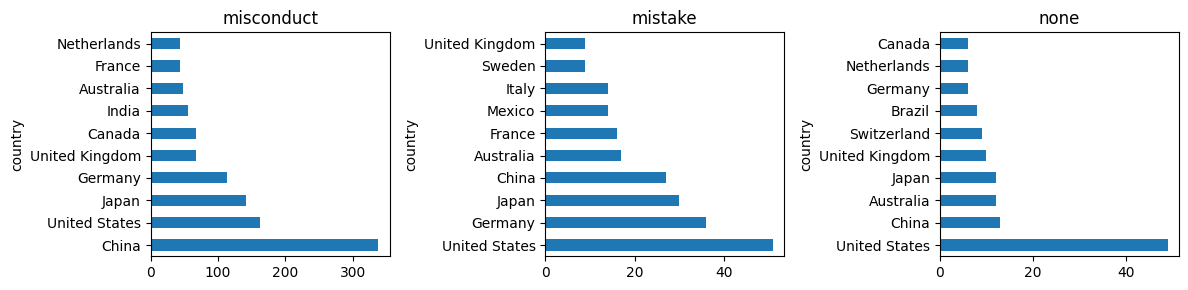

In [61]:
import pandas as pd
from collections import Counter

# Function to count top 10 countries for each category
def get_top_countries(group):
    # Flatten the list of countries in the group
    all_countries = [country for sublist in group for country in sublist]
    # Count occurrences of each country
    country_counts = Counter(all_countries)
    # Get the 10 most common countries
    return country_counts.most_common(10)

# Group by category and apply the function
top_countries_by_category = df.groupby("category")["contains_country"].apply(get_top_countries)
top_countries_by_category2 = df.groupby("category")["country_plus_city"].apply(get_top_countries)

# Convert the result to a DataFrame for better readability
result_df = top_countries_by_category.apply(pd.Series).stack().reset_index()
result_df.columns = ["category", "rank", "country_count"]
result_df[["country", "count"]] = pd.DataFrame(result_df["country_count"].tolist(), index=result_df.index)
result_df = result_df.drop(columns=["country_count"])

result_df#.groupby("category")#.plot.barh()

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=False)

for ax, (category, group) in zip(axes, result_df.groupby('category')):
    group.plot.barh(x='country', y='count', ax=ax, legend=False, title=category)
plt.tight_layout()
plt.savefig("2025-04-30 Country vs Frame.pdf")
plt.show()

In [62]:
# Create a DataFrame for plotting
dict_topic=df['dict_topic'].str.capitalize().fillna("None").value_counts()
gpt4_topic=df['category'].str.capitalize().fillna("None").value_counts()
sentiment=df['sentiment'].str.capitalize().value_counts()
type_recoded=df['Type Recoded'].str.capitalize().value_counts()
journal=df['journal'].str.capitalize().value_counts()

top_f=5
fields=df["fields"].explode().str.title().value_counts()
top_fields=fields[:top_f]
top_fields["others"]=fields[top_f:].sum()
#top_fields=top_fields.sort_values()

top_c=5
countries_A=df["country_plus_city"].explode().value_counts()
top_countries_A=countries_A[:top_c]
top_countries_A["others"]=countries_A[top_c:].sum()

countries_B=df.contains_country.explode().value_counts()
top_countries_B=countries_B[:top_c]
top_countries_B["others"]=countries_B[top_c:].sum()
countries_included=list(set(top_countries_A.index.append(top_countries_B.index)))

def categorize_decade(year, dmin_year, dmax_year, interval=10):
    # Calculate the start year based on the minimum year
    start_year = dmin_year + ((year - dmin_year) // interval) * interval
    
    # Calculate the end year
    end_year = start_year + interval - 1
    
    # Ensure the end year does not exceed the maximum year
    end_year = min(end_year, dmax_year)
    
    return f"{start_year}-{end_year} ({1+end_year-start_year} years)"

# Create the new column 'Year2' using the min and max year from the DataFrame
min_year, max_year = df['Year'].min(), df['Year'].max()
df['Year2'] = df['Year'].apply(lambda x: categorize_decade(x, min_year, max_year, interval=10))

years=df['Year2'].value_counts()
years.sort_index(inplace=True)

In [63]:
# Combine data into DataFrames
counts_df = pd.DataFrame({'dictionary': dict_topic, 'GPT4': gpt4_topic,
                          'sentiment': sentiment, 'Type Recoded': type_recoded, "Journal":journal,
                          'top_countries \n(without cities)': top_countries_B,
                          'top_countries \n(with cities)': top_countries_A,
                          'top_fields': top_fields, "years":years})



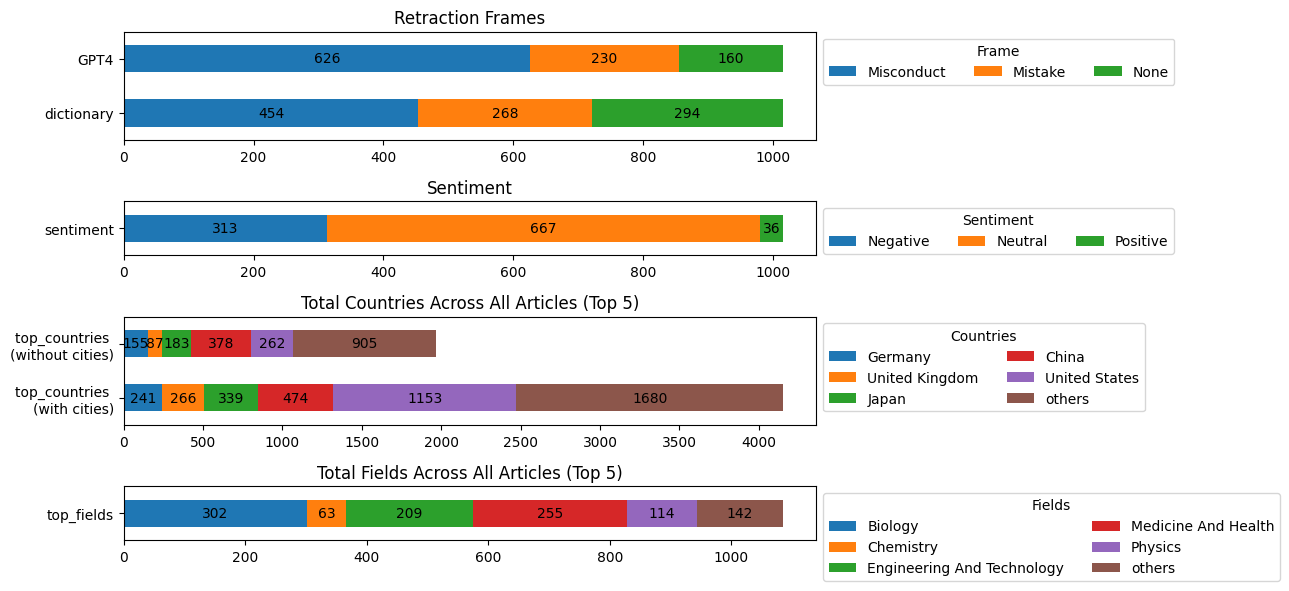

In [64]:
import matplotlib.pyplot as plt

def plot_barh(ax, data, title, legend_title, ncols=3):
    """Helper function to plot horizontal bar charts with annotations."""
    if isinstance(data,pd.Series):
        data=data.to_frame()
    
    bars = data.dropna().T.plot(kind='barh', stacked=True, ax=ax, legend=True)
    ax.set_title(title)
    ax.legend(title=legend_title, loc='upper left', bbox_to_anchor=(1, 1), ncols=ncols)
    
    # Annotate the bars with percentages
    for bar in bars.containers:
        ax.bar_label(bar, label_type='center')

# Define the plots and their titles
plot_configs = [
    (counts_df[["dictionary", "GPT4"]], 'Retraction Frames', 'Frame',3),
    (counts_df["sentiment"], 'Sentiment', 'Sentiment',3),
    #(counts_df["Type Recoded"], 'Type Recoded', 'Type Recoded',1),
#    (counts_df["Journal"], 'Journal', 'Journal'),
    (counts_df.loc[countries_included][['top_countries \n(with cities)', 'top_countries \n(without cities)']].fillna(0).sort_values('top_countries \n(with cities)'), 
     'Total Countries Across All Articles (Top 5)', 'Countries',2),
    (counts_df["top_fields"], 'Total Fields Across All Articles (Top 5)', 'Fields',2),
  #  (counts_df["years"], 'Years', 'Years',1)
]

# Create height ratios based on the number of columns in each plot
height_ratios = [1 if isinstance(config[0],pd.Series) else 2 for config in plot_configs]

# Create subplots based on the number of configurations
num_plots = len(plot_configs)
fig, axes = plt.subplots(num_plots, 1, figsize=(13, 6), sharex=False, 
                         gridspec_kw={'height_ratios': height_ratios})


# Loop through the configurations to create plots
for ax, (data, title, legend_title,ncols) in zip(axes, plot_configs):
    plot_barh(ax, data, title, legend_title,ncols)
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.savefig(today +" BarPlots.pdf")
plt.show()


In [65]:
df.category.value_counts()/df.category.shape[0]

category
misconduct    0.616142
mistake       0.226378
none          0.157480
Name: count, dtype: float64

In [66]:
df.sentiment.value_counts()/df.category.shape[0]

sentiment
neutral     0.656496
negative    0.308071
positive    0.035433
Name: count, dtype: float64

C:\Users\mr\AppData\Local\Temp\ipykernel_27632\4201151899.py:33: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  history_GPT=dfY.resample('Y').category.value_counts().unstack(level=1)[["misconduct", "mistake", "none"]].fillna(0)


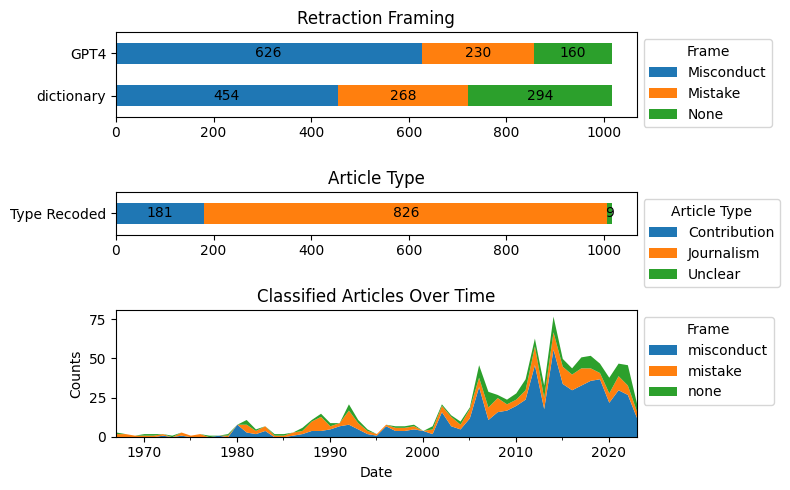

In [67]:


# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(3, 1, figsize=(8, 5), sharex=False, gridspec_kw={'height_ratios': [2,1,3]})

# Plot the first bar plot (dict_topic and GPT4_topic)
bars1=counts_df[["dictionary","GPT4"]].dropna().T.plot(kind='barh', stacked=True, ax=axes[0], legend=True)
axes[0].set_title('Retraction Framing')
#axes[0].set_ylabel('Counts')
axes[0].legend(title='Frame', loc='upper left', bbox_to_anchor=(1, 1))

# Annotate the bars with percentages
for bar in bars1.containers:
    axes[0].bar_label(bar, label_type='center')

# Plot the 3 bar plot (Type Recoded)
bars2=counts_df["Type Recoded"].to_frame().dropna().T.plot(kind='barh', stacked=True, ax=axes[1], legend=True)
axes[1].set_title('Article Type')
#axes[1].get_yaxis().set_visible(False)
#axes[1].set_ylabel('Article Type')
axes[1].legend(title='Article Type', loc='upper left', bbox_to_anchor=(1, 1),ncols=1)

# Annotate the sentiment bars with percentages
for bar in bars2.containers:
    axes[1].bar_label(bar, label_type='center')


dfY = df[(df.Date > pd.Timestamp("1966-01-01")) & 
         (df.Date < pd.Timestamp("2024-01-01"))]
dfY.set_index('Date', inplace=True)



# Resample and count occurrences of each category for the first plot
history_GPT=dfY.resample('Y').category.value_counts().unstack(level=1)[["misconduct", "mistake", "none"]].fillna(0)
history_GPT.plot.area(ax=axes[2], title="Classified Articles Over Time",lw=0)
axes[2].set_ylabel('Counts')
axes[2].legend(title='Frame', loc='upper left', bbox_to_anchor=(1, 1),ncols=1)

# Adjust layout
plt.tight_layout()
plt.show()

In [68]:
df["text_len"]=df.text.str.len()

In [69]:
with_city="contains_country_set" ### Not with city now

df["USA_others"] = df[with_city].apply(
    lambda x: ["other" if i != "United States" else i for i in x])
print(df["USA_others"].explode().value_counts())

df["China_others"] = df[with_city].apply(
    lambda x: ["other" if i != "China" else i for i in x])

df["India_others"] = df[with_city].apply(
    lambda x: ["other" if i != "India" else i for i in x])

df["Japan_others"] = df[with_city].apply(
    lambda x: ["other" if i != "Japan" else i for i in x])

df["China_USA"] = df[with_city].apply(
    lambda x: [None if i not in ["United States","China"] else i for i in x])

df["No_Country"] = df[with_city].apply(
    lambda x: True if len(x)==0 else False)

df["Misconduct_others"] = df[with_city].apply(
    lambda x: True if x=="misconduct" else False)

print(df["China_others"].explode().value_counts())

USA_others
other            925
United States    171
Name: count, dtype: int64
China_others
other    976
China    120
Name: count, dtype: int64


In [70]:
df["China_others"]

0       [other...
1              []
2       [other...
3         [other]
4              []
          ...    
1011           []
1012      [other]
1013    [other...
1014    [other...
1015    [other...
Name: China_others, Length: 1016, dtype: object

In [71]:
mc_countries=df["contains_country"].explode().value_counts()[:5].index.to_list()

df["mc5_countries"] = df["contains_country"].apply(lambda x: [i if i in mc_countries else "others" for i in x])
#df.loc[df["contains_country"].apply(lambda x: any([i in mc_countries for i in x])),"contains_country"]
df["mc5_countries"].explode().value_counts()

mc5_countries
others            905
China             378
United States     262
Japan             183
Germany           155
United Kingdom     87
Name: count, dtype: int64

In [72]:
retraction_watch = pd.read_excel("RetractionWatch_DB_Full.xlsx")#[["Total", "Retraction Rate"]].dropna()
country=retraction_watch.loc[retraction_watch['Retraction Rate'].apply(lambda x: isinstance(x,str)),'Retraction Rate']#.shift()
country.index=country.index+1
retraction_watch["Country"]=country
retraction_watch.dropna(subset="Total",inplace=True)
retraction_watch.set_index("Country",inplace=True)
retraction_watch=retraction_watch[retraction_watch.Total>100]

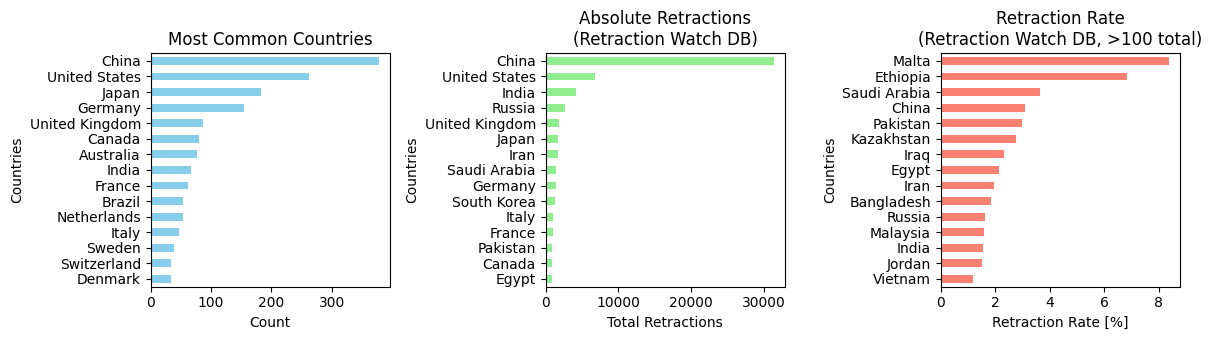

In [73]:
d(500)

bla=df["contains_country"].apply(lambda x: list(x)).explode("contains_country")

# Create a figure with three subplots arranged horizontally
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5))

# Plot 1: Most common countries
bla.value_counts(ascending=True)[-15:].plot.barh(ax=ax1, color='skyblue')
ax1.set_title("Most Common Countries")
ax1.set_xlabel("Count")
ax1.set_ylabel("Countries")

# Plot 2: Absolute Retractions
#retraction_watch = pd.read_excel("RetractionWatch_DB.xlsx", index_col="Country")[["Total", "Retraction Rate"]].dropna()
retraction_watch.Total.sort_values(ascending=True)[-15:].plot.barh(ax=ax2, color='lightgreen')
ax2.set_title("Absolute Retractions\n(Retraction Watch DB)")
ax2.set_xlabel("Total Retractions")
ax2.set_ylabel("Countries")

# Plot 3: Retraction Rate
retraction_watch["Retraction Rate"].sort_values(ascending=True)[-15:].plot.barh(ax=ax3, color='salmon')
ax3.set_title("Retraction Rate\n(Retraction Watch DB, >100 total)")
ax3.set_xlabel("Retraction Rate [%]")
ax3.set_ylabel("Countries")

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig("2025-07-07 RetractionWatch vs Mentions.pdf")
# Display the plot
plt.show()

In [74]:
df["Type Recoded"]=df["Type Recoded"].replace("Unclear",None)

In [75]:
#dependency of 3 value category (mistake vs. misconduct vs. none)

# List of columns to test against "GPT4"
columns_to_test = ["contains_country",'country_plus_city',
                   "contains_country_set",'country_plus_city_set',
                   "fields","fields_set",'Type Recoded', 'sentiment',
                   'journal',"USA_others",
                #   "Japan_others","India_others",
                   "China_others","China_USA"]

def highlight_significant(s):
    return ['background-color: lightgreen' if v < 0.05 else '' for v in s]

def CHI2_tests(df,columns_to_test,dependent_variable='category'):
    from scipy.stats import chi2, chi2_contingency
    
    # Initialize a list to store results
    results_list = []
    crosstabs={}
    
    # Loop through each column and perform the chi-squared test
    for col in columns_to_test:
        try:

            # Check if the column contains list-like values and explode if necessary
            if df[col].apply(lambda x: isinstance(x, list)).any():
               # df[col]=df[col].dropna()
                ### RELEVANT
                #df[col]=df[col].apply(lambda x: list(set(x))if isinstance(x, list) else []) <-- Only one or more values per article?
                ### RELEVANT
                dfx=df.explode(col)  # Create a set and explode the DataFrame if the column contains multiple values
                mc5 = dfx[col].value_counts()[:5].index.to_list()  # Get the top 5 values
                print(mc5)
                dfx = dfx[dfx[col].isin(mc5)] # Filter the DataFrame to include only top 5 values
                crosstab = pd.crosstab(dfx[col], dfx[dependent_variable])
            else:
                crosstab = pd.crosstab(df[col], df[dependent_variable])
        except:
            print(col)
            
        crosstabs[col]=crosstab
        # Perform the chi-squared test
        chi2_stat, p, dof, expected = chi2_contingency(crosstab)
        
        # Calculate the 95% confidence interval
        lower_bound = chi2.ppf(0.025, dof)  # Lower bound for 95% CI
        upper_bound = chi2.ppf(0.975, dof)  # Upper bound for 95% CI
        
        # Append the results to the list
        results_list.append({
            'Column': col,
            'Chi2': chi2_stat,
            'p-value': p,
            'dof': dof,
            "min_counts":  crosstab.min().min()
         #   '95% CI Lower Bound': lower_bound,
         #   '95% CI Upper Bound': upper_bound
        })
    
    # Create a DataFrame from the results list
    results_df = pd.DataFrame(results_list).style.apply(highlight_significant, subset=['p-value'])
    return results_df, crosstabs



In [76]:
#CHI2_tests(df,columns_to_test,dependent_variable='category')

In [77]:
results_df,crosstabs=CHI2_tests(df,columns_to_test,dependent_variable='category')
results_df.to_excel("2025_04_02 Statistical Tests_1.xlsx")
results_df

['China', 'United States', 'Japan', 'Germany', 'United Kingdom']
['United States', 'China', 'Japan', 'United Kingdom', 'Germany']
['United States', 'China', 'Germany', 'Japan', 'United Kingdom']
['United States', 'United Kingdom', 'China', 'Germany', 'Japan']
['Biology', 'Medicine and Health', 'Engineering and Technology', 'Physics', 'Chemistry']
['Biology', 'Medicine and Health', 'Engineering and Technology', 'Physics', 'Chemistry']
['other', 'United States']
['other', 'China']
['United States', 'China']


,Column,Chi2,p-value,dof,min_counts
0,contains_country,93.546240,0.000000,8,6
1,country_plus_city,109.252693,0.000000,8,11
2,contains_country_set,12.901382,0.115288,8,5
3,country_plus_city_set,16.937844,0.030763,8,7
4,fields,15.570478,0.048957,8,5
5,fields_set,5.570769,0.695187,8,4
6,Type Recoded,31.103982,0.000000,2,46
7,sentiment,19.001023,0.000786,4,8
8,journal,0.249367,0.882776,2,61
9,USA_others,3.059633,0.216575,2,25


In [78]:
df["contains_country"].explode().value_counts()[:10]

contains_country
China             378
United States     262
Japan             183
Germany           155
United Kingdom     87
Canada             80
Australia          77
India              67
France             62
Brazil             54
Name: count, dtype: int64

In [79]:
df.replace("none",None).replace("mistake",None).category.value_counts()

category
misconduct    626
Name: count, dtype: int64

In [80]:
results_df,crosstabs=CHI2_tests(df.replace("none","other").replace("mistake","other"),columns_to_test,dependent_variable='category')
results_df.to_excel("2025_03_27 Statistical Tests_Misconduct_vs_Rest.xlsx")
results_df


['China', 'United States', 'Japan', 'Germany', 'United Kingdom']
['United States', 'China', 'Japan', 'United Kingdom', 'Germany']
['United States', 'China', 'Germany', 'Japan', 'United Kingdom']
['United States', 'United Kingdom', 'China', 'Germany', 'Japan']
['Biology', 'Medicine and Health', 'Engineering and Technology', 'Physics', 'Chemistry']
['Biology', 'Medicine and Health', 'Engineering and Technology', 'Physics', 'Chemistry']
['other', 'United States']
['other', 'China']
['United States', 'China']


,Column,Chi2,p-value,dof,min_counts
0,contains_country,68.850326,0.000000,4,19
1,country_plus_city,96.819963,0.000000,4,64
2,contains_country_set,6.966167,0.137687,4,17
3,country_plus_city_set,15.421579,0.003902,4,23
4,fields,6.179550,0.186135,4,28
5,fields_set,1.352361,0.852431,4,19
6,Type Recoded,28.644268,0.000000,1,80
7,sentiment,16.396856,0.000275,2,18
8,journal,0.000000,1.000000,1,143
9,USA_others,2.212815,0.136869,1,61


In [81]:
dependet_variable='category'
results_df,crosstabs=CHI2_tests(df.replace("none",None),columns_to_test,dependent_variable='category')
results_df.to_excel("2025_03_27 Statistical Tests_2.xlsx")
results_df


['China', 'United States', 'Japan', 'Germany', 'United Kingdom']
['United States', 'China', 'Japan', 'United Kingdom', 'Germany']
['United States', 'China', 'Germany', 'Japan', 'United Kingdom']
['United States', 'United Kingdom', 'China', 'Germany', 'Japan']
['Biology', 'Medicine and Health', 'Engineering and Technology', 'Physics', 'Chemistry']
['Biology', 'Medicine and Health', 'Engineering and Technology', 'Physics', 'Chemistry']
['other', 'United States']
['other', 'China']
['United States', 'China']


,Column,Chi2,p-value,dof,min_counts
0,contains_country,39.398787,0.000000,4,9
1,country_plus_city,56.259452,0.000000,4,46
2,contains_country_set,4.684748,0.321200,4,8
3,country_plus_city_set,8.816632,0.065850,4,15
4,fields,9.832318,0.043349,4,23
5,fields_set,2.955888,0.565234,4,15
6,Type Recoded,15.617966,0.000078,1,55
7,sentiment,12.480297,0.001950,2,8
8,journal,0.029047,0.864671,1,82
9,USA_others,0.687179,0.407126,1,36


In [82]:
results_df,crosstabs=CHI2_tests(df.replace("none",None),columns_to_test,dependent_variable='Type Recoded')
results_df


['China', 'United States', 'Japan', 'Germany', 'United Kingdom']
['United States', 'China', 'Japan', 'United Kingdom', 'Germany']
['United States', 'China', 'Germany', 'Japan', 'United Kingdom']
['United States', 'United Kingdom', 'China', 'Germany', 'Japan']
['Biology', 'Medicine and Health', 'Engineering and Technology', 'Physics', 'Chemistry']
['Biology', 'Medicine and Health', 'Engineering and Technology', 'Physics', 'Chemistry']
['other', 'United States']
['other', 'China']
['United States', 'China']


,Column,Chi2,p-value,dof,min_counts
0,contains_country,31.928736,0.000002,4,6
1,country_plus_city,45.488414,0.000000,4,8
2,contains_country_set,6.434838,0.168943,4,5
3,country_plus_city_set,8.120539,0.087261,4,5
4,fields,22.091447,0.000192,4,2
5,fields_set,9.023432,0.060516,4,2
6,Type Recoded,1000.228757,0.000000,1,0
7,sentiment,2.850868,0.240404,2,9
8,journal,0.550647,0.458054,1,62
9,USA_others,2.473695,0.115766,1,26


In [83]:
results_df,crosstabs=CHI2_tests(df.replace("none",None),columns_to_test,dependent_variable='journal')
results_df.to_excel("2025_03_27 Statistical Tests_4.xlsx")
results_df

['China', 'United States', 'Japan', 'Germany', 'United Kingdom']
['United States', 'China', 'Japan', 'United Kingdom', 'Germany']
['United States', 'China', 'Germany', 'Japan', 'United Kingdom']
['United States', 'United Kingdom', 'China', 'Germany', 'Japan']
['Biology', 'Medicine and Health', 'Engineering and Technology', 'Physics', 'Chemistry']
['Biology', 'Medicine and Health', 'Engineering and Technology', 'Physics', 'Chemistry']
['other', 'United States']
['other', 'China']
['United States', 'China']


,Column,Chi2,p-value,dof,min_counts
0,contains_country,13.117581,0.010715,4,42
1,country_plus_city,37.326970,0.000000,4,102
2,contains_country_set,6.711371,0.151950,4,24
3,country_plus_city_set,5.344588,0.253732,4,30
4,fields,15.667224,0.003500,4,26
5,fields_set,6.631027,0.156720,4,20
6,Type Recoded,0.550647,0.458054,1,62
7,sentiment,3.649820,0.161232,2,11
8,journal,1011.695746,0.000000,1,0
9,USA_others,0.221202,0.638125,1,66


In [84]:
results_df

,Column,Chi2,p-value,dof,min_counts
0,contains_country,13.117581,0.010715,4,42
1,country_plus_city,37.326970,0.000000,4,102
2,contains_country_set,6.711371,0.151950,4,24
3,country_plus_city_set,5.344588,0.253732,4,30
4,fields,15.667224,0.003500,4,26
5,fields_set,6.631027,0.156720,4,20
6,Type Recoded,0.550647,0.458054,1,62
7,sentiment,3.649820,0.161232,2,11
8,journal,1011.695746,0.000000,1,0
9,USA_others,0.221202,0.638125,1,66


['China', 'United States', 'Japan', 'Germany', 'United Kingdom']
['United States', 'China', 'Japan', 'United Kingdom', 'Germany']
['United States', 'China', 'Germany', 'Japan', 'United Kingdom']
['United States', 'United Kingdom', 'China', 'Germany', 'Japan']
['Biology', 'Medicine and Health', 'Engineering and Technology', 'Physics', 'Chemistry']
['Biology', 'Medicine and Health', 'Engineering and Technology', 'Physics', 'Chemistry']
['other', 'United States']
['other', 'China']
['United States', 'China']
p-value = 0.04539315665158055
chi-value = 6.184787839686225


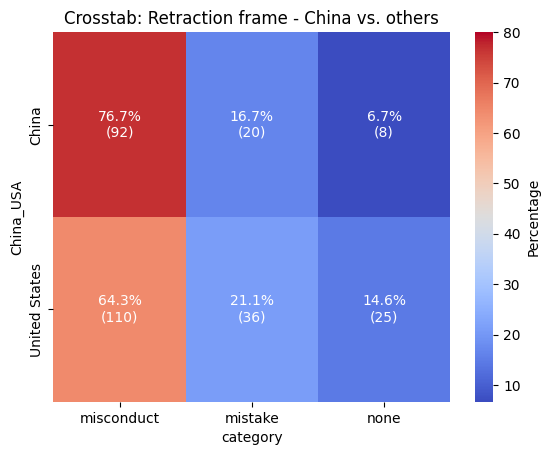

In [86]:
results_df,crosstabs=CHI2_tests(df,columns_to_test,dependent_variable='category')


crosstab=crosstabs['China_USA'].T

import seaborn as sns



percentages = crosstab.T.apply(lambda r: r/r.sum().sum()*100, axis=1)

# Create custom annotations
annotations = percentages.round(1).astype(str) + "%" + "\n(" + crosstab.T.astype(str) +")"

# Plot the heatmap
sns.heatmap(percentages, annot=annotations, cmap="coolwarm", fmt="", cbar_kws={'label': 'Percentage'}, vmax=80)
plt.title("Crosstab: Retraction frame - China vs. others")

from scipy.stats import chi2_contingency
c, p, dof, expected = chi2_contingency(crosstab)


print("p-value =", p)
print("chi-value =", c)

<Axes: xlabel='category', ylabel='Type Recoded'>

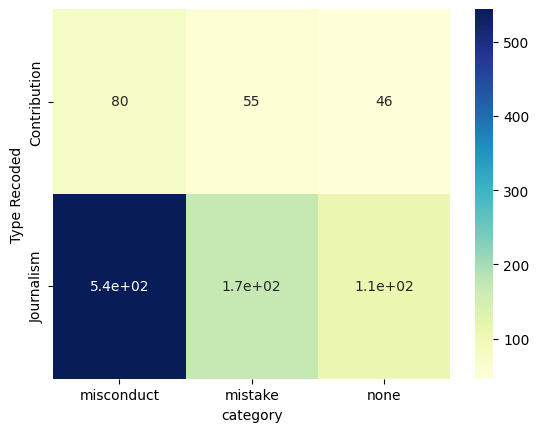

In [87]:
sns.heatmap(crosstabs["Type Recoded"], annot=True, cmap="YlGnBu")

# Time Rows & Correlation

In [88]:
df.Year.min()

np.int64(1963)

C:\Users\mr\AppData\Local\Temp\ipykernel_27632\3598279564.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  history_GPT=dfY.resample('Y').category.value_counts().unstack(level=1)[["misconduct", "mistake", "none"]].fillna(0)
C:\Users\mr\AppData\Local\Temp\ipykernel_27632\3598279564.py:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  history_GPT5Y = dfY.resample("5Y").apply(lambda x: dict(Counter(x["category"]))).apply(pd.Series)


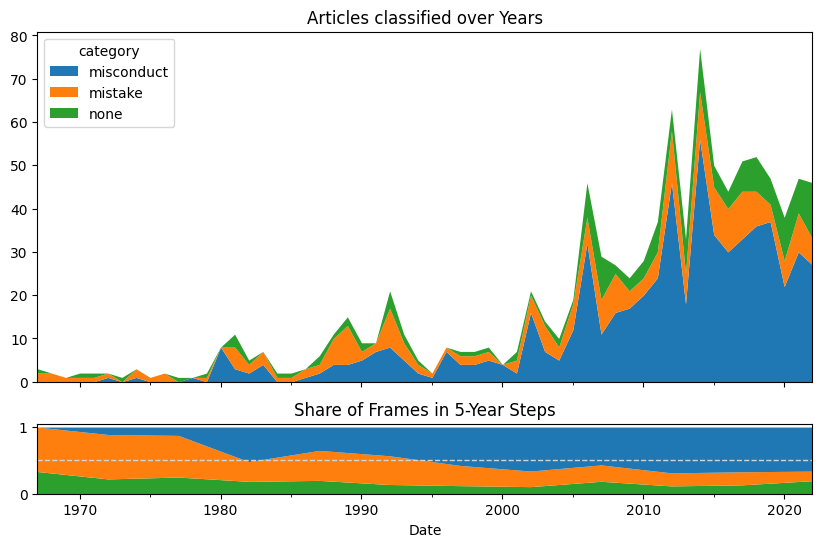

In [89]:
dfY = df[(df.Date > pd.Timestamp("1967-01-01")) & 
         (df.Date < pd.Timestamp("2023-01-01"))]
dfY.set_index('Date', inplace=True)

colors = {"misconduct": "#1f77b4", "mistake": "#ff7f0e", "none": "#2ca02c"}

# Create subplots: 1 column, 2 rows
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [5, 1]})

# Resample and count occurrences of each category for the first plot
history_GPT=dfY.resample('Y').category.value_counts().unstack(level=1)[["misconduct", "mistake", "none"]].fillna(0)
history_GPT.plot.area(ax=axes[0], title="Articles classified over Years",lw=0, color=colors)

# Resample for 5-year intervals and calculate percentages for the second plot
history_GPT5Y = dfY.resample("5Y").apply(lambda x: dict(Counter(x["category"]))).apply(pd.Series)
history_GPT5Y_perc = history_GPT5Y.divide(history_GPT5Y.sum(axis=1), axis=0)
history_GPT5Y_perc.plot.area(ax=axes[1], lw=0, stacked=True, title="Share of Frames in 5-Year Steps", color=colors, legend=False)


# Add a dotted horizontal line at y=0.5 in the second plot
axes[1].axhline(y=0.5, color='lightgrey', linestyle='--', linewidth=1)

plt.savefig(today+" Articles classified over years.pdf")

In [90]:
dfY["mc5_countries"].explode().value_counts()

mc5_countries
others            890
China             375
United States     257
Japan             183
Germany           153
United Kingdom     86
Name: count, dtype: int64

C:\Users\mr\AppData\Local\Temp\ipykernel_27632\1270128102.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resu=dfY.explode("mc5_countries").resample('12M')["mc5_countries"].value_counts().unstack(level=1).fillna(0)#


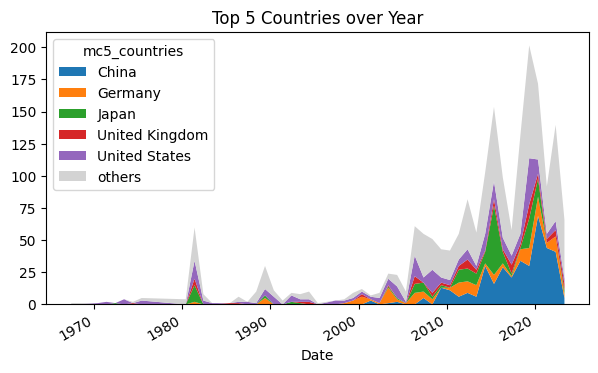

In [91]:
resu=dfY.explode("mc5_countries").resample('12M')["mc5_countries"].value_counts().unstack(level=1).fillna(0)#
colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "lightgrey"]

resu.plot.area(stacked=True,linewidth=0,title="Top 5 Countries over Year",color=colors,figsize=(7,4))

resu.sum() 


plt.savefig(today+" article_country_yearwise.pdf")

C:\Users\mr\AppData\Local\Temp\ipykernel_27632\1098397639.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_counts =dfY.resample('Y').Type.size().fillna(0)


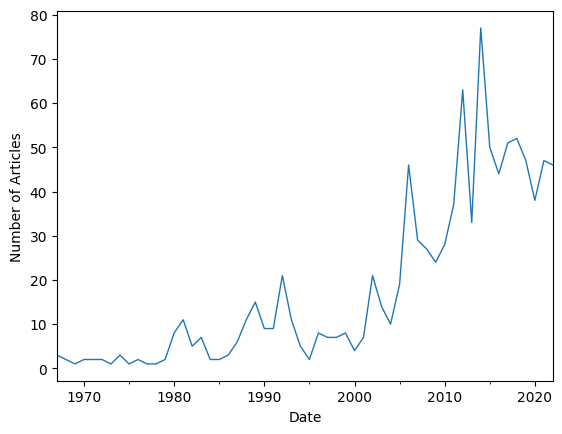

In [92]:
annual_counts =dfY.resample('Y').Type.size().fillna(0)
annual_counts.plot(linewidth=1, ylabel="Number of Articles")
plt.savefig(today+"carticle_Count_yearwise.pdf")

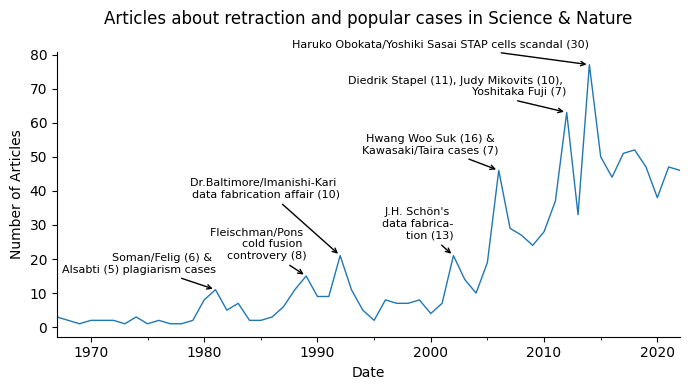

In [93]:
import matplotlib.pyplot as plt

# Assuming `annual_counts` is already defined as in your code
annual_counts = dfY.resample('YE').Type.size().fillna(0)

# Plot the time series
ax=annual_counts.plot(linewidth=1, ylabel="Number of Articles", figsize=(7,4))


ax.set_title("Articles about retraction and popular cases in Science & Nature", pad=20)
# Add annotations for specific years
annotations = {
    1981: "Soman/Felig (6) & \nAlsabti (5) plagiarism cases",
    1989: "Fleischman/Pons \ncold fusion \ncontrovery (8)",
    1992: "Dr.Baltimore/Imanishi-Kari \ndata fabrication affair (10)",
    2002: "J.H. Schön's \ndata fabrica-\ntion (13)",
    2006: "Hwang Woo Suk (16) & \nKawasaki/Taira cases (7)",
    2012: "Diedrik Stapel (11), Judy Mikovits (10), \nYoshitaka Fuji (7)",
    2014: "Haruko Obokata/Yoshiki Sasai STAP cells scandal (30)"
}

case_counts = { 1981: 6+5, 1989: 8, 1992: 10, 2002: 13, 2006: 16+17, 2012: 11+10+7, 2014: 30 }

for year, text in annotations.items():
    # Get the value for the specific year
    value = annual_counts.loc[str(year)].iloc[0]

    if year==1992:
        k=12
    else:
        k=0
    
    # Add annotation with an arrow
    plt.annotate(
        text, 
        xy=(pd.Timestamp(str(year)), value),  # Point to the year and its value
        xytext=(pd.Timestamp(str(year)), value + 5+k),  # Offset the text above the point
        arrowprops=dict(facecolor='black', arrowstyle="->"),
        fontsize=8,
        ha='right'
    )

# Save the plot
import seaborn as sns
sns.despine()
plt.tight_layout()

plt.savefig(today + " article_Count_yearwise_annotated.pdf")

misconduct: coefficient = 0.69, p-value = 0.0410
mistake: coefficient = -0.81, p-value = 0.0076
none: coefficient = 0.28, p-value = 0.47


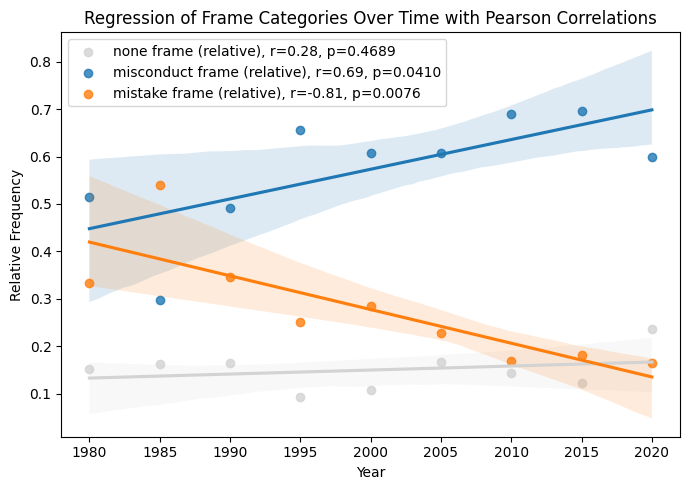

In [99]:

## SEABORN REGPLOT With Datetime 

dfY = df[(df.Date > pd.Timestamp("1970-01-01")) & 
         (df.Date < pd.Timestamp("2025-01-01"))]

dfY.set_index('Date', inplace=True)

df5Y=dfY.resample("5YS").apply(lambda x: dict(Counter(x["category"]))).apply(pd.Series).iloc[2:,:]
df5Y_perc=df5Y.divide(df5Y.sum(axis=1), axis=0)
df5Y_perc=df5Y_perc




# fill the 100% none frame where there are not many articles wtith 0.
df5Y_perc=df5Y_perc.fillna(0)


from scipy import stats


df5Y_perc_Year=[i.date().year for i in df5Y_perc.index.to_list()]

Pearson_misconduct=stats.pearsonr(df5Y_perc_Year,df5Y_perc["misconduct"])
Pearson_mistake=stats.pearsonr(df5Y_perc_Year,df5Y_perc["mistake"])
Pearson_none=stats.pearsonr(df5Y_perc_Year,df5Y_perc["none"])
print(f"misconduct: coefficient = {Pearson_misconduct[0]:.2f}, p-value = {Pearson_misconduct[1]:.4f}")
print(f"mistake: coefficient = {Pearson_mistake[0]:.2f}, p-value = {Pearson_mistake[1]:.4f}")
print(f"none: coefficient = {Pearson_none[0]:.2f}, p-value = {Pearson_none[1]:.2f}")


# Plotting
f, ax = plt.subplots(figsize=(7, 5))

# Plot regression lines with scatter
sns.regplot(x=df5Y_perc_Year, y=df5Y_perc['none'], label=f"none frame (relative), r={Pearson_none[0]:.2f}, p={Pearson_none[1]:.4f}", color="lightgray", ax=ax)
sns.regplot(x=df5Y_perc_Year, y=df5Y_perc['misconduct'], label=f"misconduct frame (relative), r={Pearson_misconduct[0]:.2f}, p={Pearson_misconduct[1]:.4f}", ax=ax)
sns.regplot(x=df5Y_perc_Year, y=df5Y_perc['mistake'], label=f"mistake frame (relative), r={Pearson_mistake[0]:.2f}, p={Pearson_mistake[1]:.4f}", ax=ax)

ax.legend(loc="best")
ax.set_xlabel("Year")
ax.set_ylabel("Relative Frequency")
plt.title("Regression of Frame Categories Over Time with Pearson Correlations")

plt.tight_layout()
plt.savefig("Pearson_Correlation_of_frames_over_time.pdf")
plt.show()

# Statistics with Field & Discipline

<Axes: title={'center': 'Most common countries (1 per article)'}, ylabel='Most Common country'>

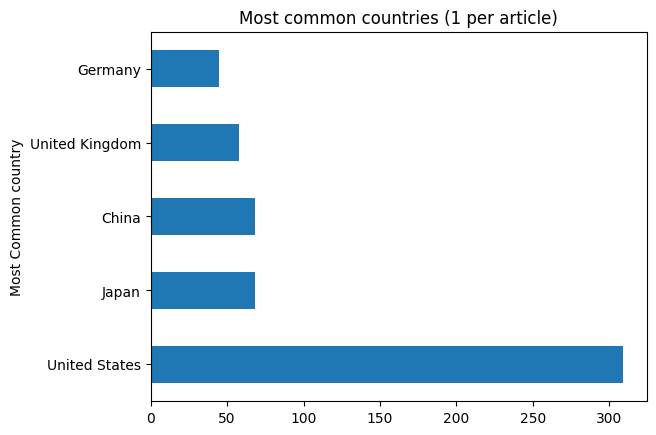

In [100]:
CnF_mcC10=df['Most Common country'].value_counts()[:5]
CnF_mcD10=df['most_common_fields'].explode().value_counts()[:5]
most_common_10countries=CnF_mcC10.index
CnF_mcC10[:10].plot.barh(title="Most common countries (1 per article)")

<Axes: title={'center': 'Most common fields'}, ylabel='most_common_fields'>

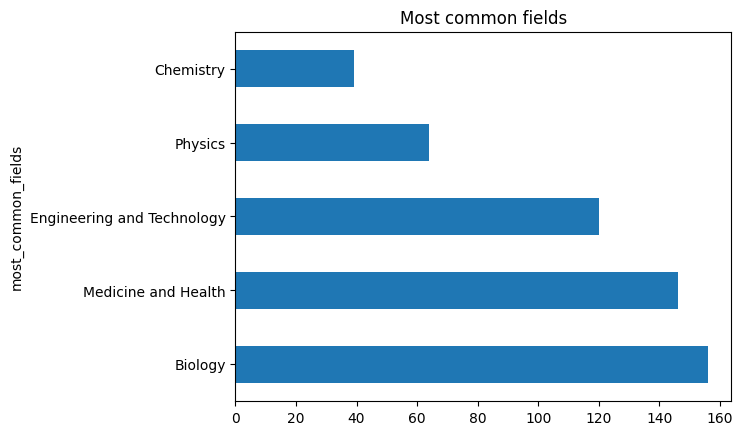

In [101]:
CnF_mcD10=df['most_common_fields'].explode().value_counts()[:5]
most_common_10disciplines=CnF_mcD10.index
CnF_mcD10.plot.barh(title="Most common fields")


In [102]:
CnF_mcC10

Most Common country
United States     309
Japan              68
China              68
United Kingdom     58
Germany            45
Name: count, dtype: int64

In [103]:
df["country_top"]=df['Most Common country'][df['Most Common country'].isin(most_common_10countries)]
df["discipline_top"] = df["most_common_fields"].apply(
    lambda x: [i for i in x if i in most_common_10disciplines] if isinstance(x, list) else []
)

In [104]:
df[["discipline_top","country_top","category","Type Recoded"]]

,discipline_top,country_top,category,Type Recoded
0,[],NaN,misconduct,Journalism
1,[],NaN,misconduct,Journalism
2,[Chemistry],NaN,mistake,Journalism
3,[],Japan,misconduct,Journalism
4,[Biology],NaN,misconduct,Journalism
...,...,...,...,...
1011,"[Engineering and Technology, Medicine and Health]",United States,misconduct,Journalism
1012,[Medicine and Health],NaN,none,Journalism
1013,[],NaN,misconduct,Journalism
1014,[],NaN,misconduct,Journalism


p-value = 0.6384831277673169
chi-value = 6.078105935718034


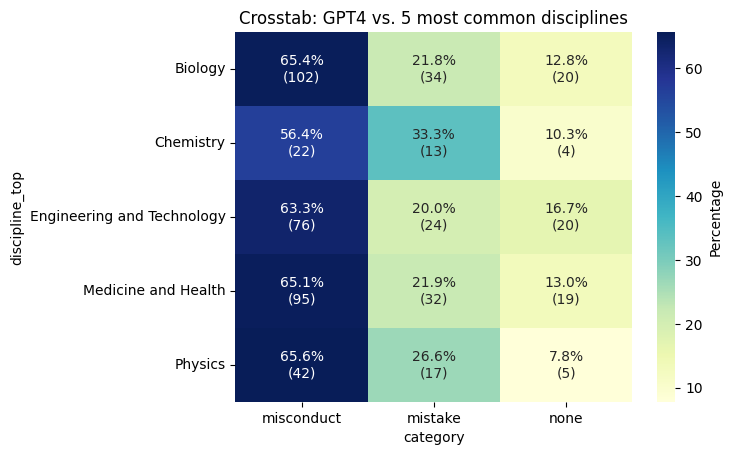

In [105]:

df_exploded=df.explode("discipline_top")[["category","discipline_top"]]


import seaborn as sns
crosstab=pd.crosstab(df_exploded["category"], df_exploded["discipline_top"]).T
percentages = crosstab.apply(lambda r: r/r.sum().sum()*100, axis=1)

# Create custom annotations
annotations = percentages.round(1).astype(str) + "%" + "\n(" + crosstab.astype(str) +")"

# Plot the heatmap
sns.heatmap(percentages, annot=annotations, cmap="YlGnBu", fmt="", cbar_kws={'label': 'Percentage'})
plt.title("Crosstab: GPT4 vs. 5 most common disciplines")

from scipy.stats import chi2_contingency
c, p, dof, expected = chi2_contingency(crosstab)


print("p-value =", p)
print("chi-value =", c)

# Extra Plots

In [ ]:
MC=df[df.category=="misconduct"]["NoStopwords"].explode().value_counts()[:50]
MT=df[df.category=="mistake"]["NoStopwords"].explode().value_counts()[:50]
All=df["NoStopwords"].explode().value_counts()[:50]


In [ ]:
df.loc[(df.filtered_texts.apply(lambda x: len("".join(x))<50)),["text","category","explanation"]]

In [ ]:
df.loc[(df.category=="misconduct")&(df.filtered_texts.apply(lambda x: len("".join(x))<50)),["text","explanation"]]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Calculate value counts for each category
MC = df[df.category == "misconduct"]["NoStopwords"].explode().value_counts()[:50]
MT = df[df.category == "mistake"]["NoStopwords"].explode().value_counts()[:50]
All = df["NoStopwords"].explode().value_counts()[:50]

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# List of word frequency Series and corresponding titles
word_freqs = [All, MC, MT]
titles = ['Most Common Lemmata (All)', 'Most Common Lemmata (Mistake Frame)', 'Most Common Lemmata (Misconduct Frame)']

# Generate and display each word cloud
for ax, word_freq, title in zip(axes, word_freqs, titles):
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freq)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')  # Hide the axes

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Keywords over time

In [ ]:
# Resample by 4 years and aggregate
result = dfY.dropna(subset="keywords_likely").resample('5A').agg(
    joined_text=('text', lambda x: "".join(x)),
    joined_keywords=('keywords_likely', list),
    text_count=('text', 'count'))

result.joined_keywords_only=result.joined_keywords.apply(lambda x: [(j[0].lstrip("of"),j[1]) for i in x for j in i if "_" not in j[0]])


In [ ]:
all_keywords=dfY.keywords_only.explode().to_list()

pattern=[i[0] for i in result.joined_keywords.explode().explode().to_list()]
from collections import Counter
most_common_keywords=[i[0] for i in Counter(all_keywords).most_common(50)]

most_common_keywords

In [ ]:
d(300)
import re
pattern = re.compile('|'.join(map(re.escape, most_common_keywords)))

result["filtered_keywords"]=result.joined_keywords_only.apply(lambda x: [i for i in x if not pattern.search(i[0])])
result["filtered_keywords"] = result["filtered_keywords"].apply(lambda x: sorted(x, key=lambda y: y[1], reverse=True))
result["filtered_keywords"] = result["filtered_keywords"].apply(lambda x: list(dict.fromkeys([i[0] for i in x])))


In [ ]:
# Function to filter similar words in a list

#!python -m spacy download en_core_web_lg
import spacy
# Enable GPU support
spacy.prefer_gpu()

# Load the spaCy model with word vectors
nlp=spacy.load("en_core_web_lg")



# Function to filter similar words in a list and return their lemmas
def filter_similar_words(word_list):
    unique_words = []
    tokens = list(nlp.pipe(word_list))  # Process all words in the list at once
    for token in tokens:
        if token[0].pos_ == "NOUN":  # Check if the token is a noun
            if not any(token[0].similarity(existing_token) > 0.70 for existing_token in unique_words):
                unique_words.append(token[0])  # Store the lemma instead of the token
    unique_words=[token.lemma_ for token in unique_words]
    return unique_words  # Return the list of unique lemmas

# Apply the function to the DataFrame column
result["filtered_keywords_result"] = result["filtered_keywords"].progress_apply(filter_similar_words)


In [ ]:
result[["filtered_keywords_result","filtered_keywords"]].sample(5)

In [ ]:
result["filtered_keywords2"]=result["filtered_keywords_result"].apply(lambda x: list(dict.fromkeys([i for i in x if ((len(i)<14)&(len(i)>4))])))

import textwrap

result["keywords_wrapped"] = result["filtered_keywords2"].apply(
    lambda x: '\n'.join(textwrap.wrap(' '.join(x), width=2)))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
f=result.text_count.plot(figsize=(17,10),
                         title="Article count with 'retration' over time: 5 Year steps with unique noun keywords (KeyBert, Spacy vector similarity)",lw=0)

# Fill the area under the curve
plt.fill_between(result.index, result['text_count'], color='lightblue', alpha=0.4)

# Fill the area with keywords
for i, row in result.iterrows():
# Calculate the position for the keyword
    y_position = row['text_count'] / 2  # Position the keyword in the middle of the filled area
    n_words=int(row['text_count']*0.10)+1

    plt.text(i, 1, "\n".join(row['filtered_keywords2'][:n_words]), ha='center', va='bottom', fontsize=11, color='black', family='serif',linespacing=2)



sns.despine(left=True, bottom=True)
plt.show()

f.get_figure().savefig("history_keywords.pdf", bbox_inches='tight')